# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [1]:
from pyberries.data import DatasetPool, get_histogram
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['240424_1', '240612_1', '240620_1',
                            '240424_2', '240612_2', '240620_2',
                            '240424_3', '240612_3', '240619_1',
                            '240424_4', '240612_4', '240619_2',
                            '240606_1', '240606_3', '240619_3',
                            '240606_2', '240606_4', '240619_4',
                            ],
                    groups=['WT, 0', 'WT, 0', 'WT, 0',
                            'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL',
                            'ΔrecA, 0', 'ΔrecA, 0', 'ΔrecA, 0',
                            'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL', 'ΔrecA, 30 ng/mL',
                            'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0',
                            'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL'
                            ],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name=['Nucleoid', 'RecB_spots'])
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 240424_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2 (group WT, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_2 (group WT, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_2 (group WT, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_3 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_3 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240619_1 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_4 (group ΔrecA, 30 

In [ ]:
data.describe()

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

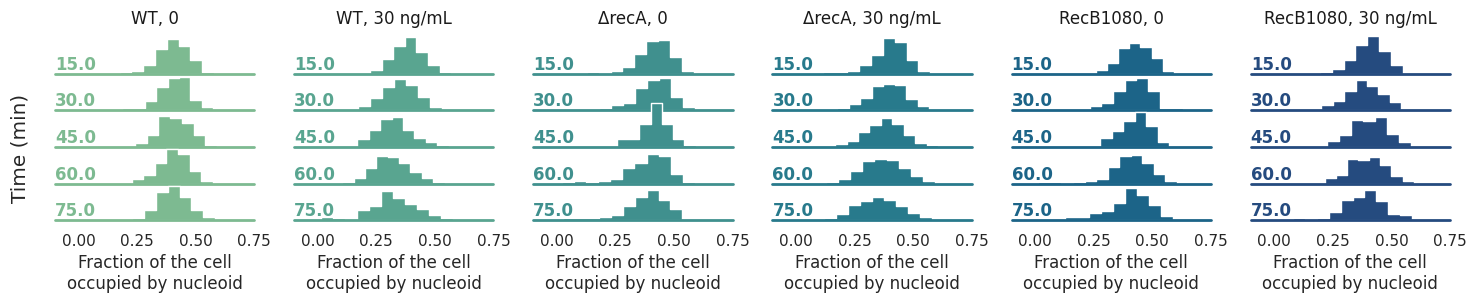

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Group", aspect=6, height=.5, palette='crest')
g.map(sns.histplot, 'frac_nucleoid', binwidth=0.05, common_norm=False, stat='probability', alpha=1, element='step', edgecolor='w')

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.2)
g.figure.supylabel('Time (min)', x=.1, y=.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Fraction of the cell\noccupied by nucleoid', xlim=(-0.1,0.75))
g.despine(bottom=True, left=True)
plt.show()

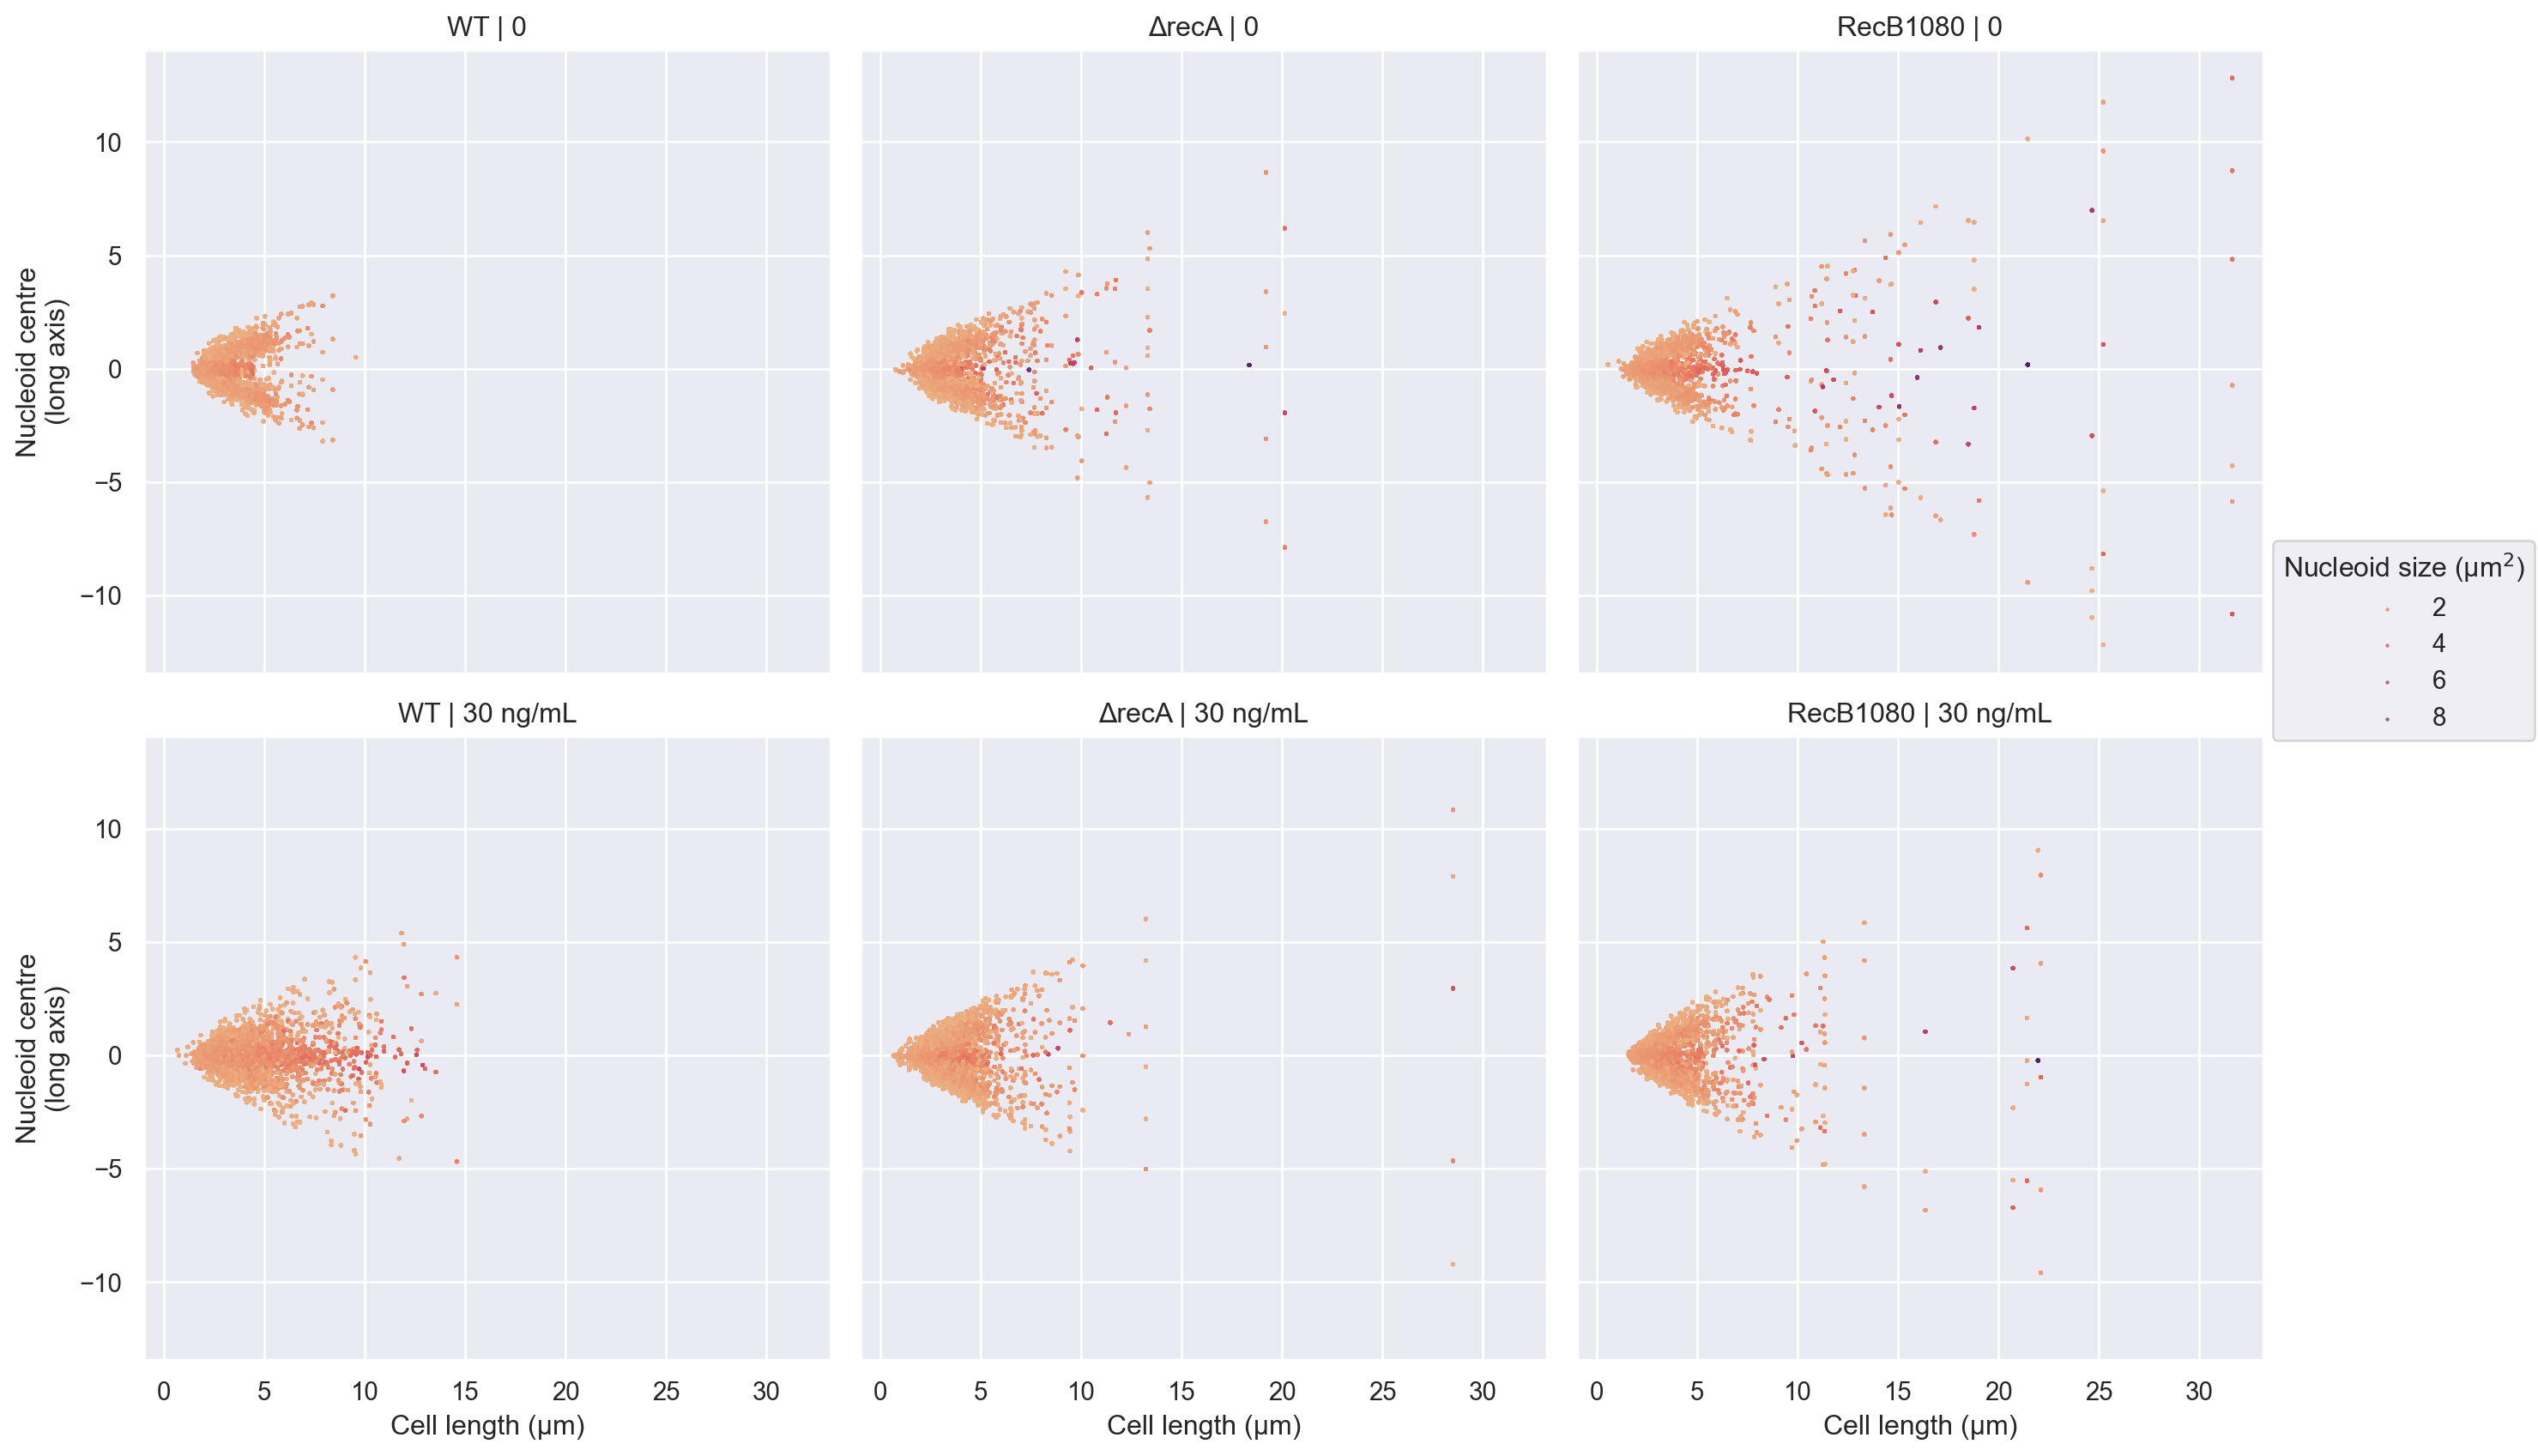

In [33]:
(
    so.Plot(data.Nucleoid, x='SpineLength', y='centerLongCoord', color='Nucleoid_size')
    .layout(size=(14,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=2))
    # .limit(x=(None, 15), y=(-5, 5))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Nucleoid size (µm$^2$)')
)

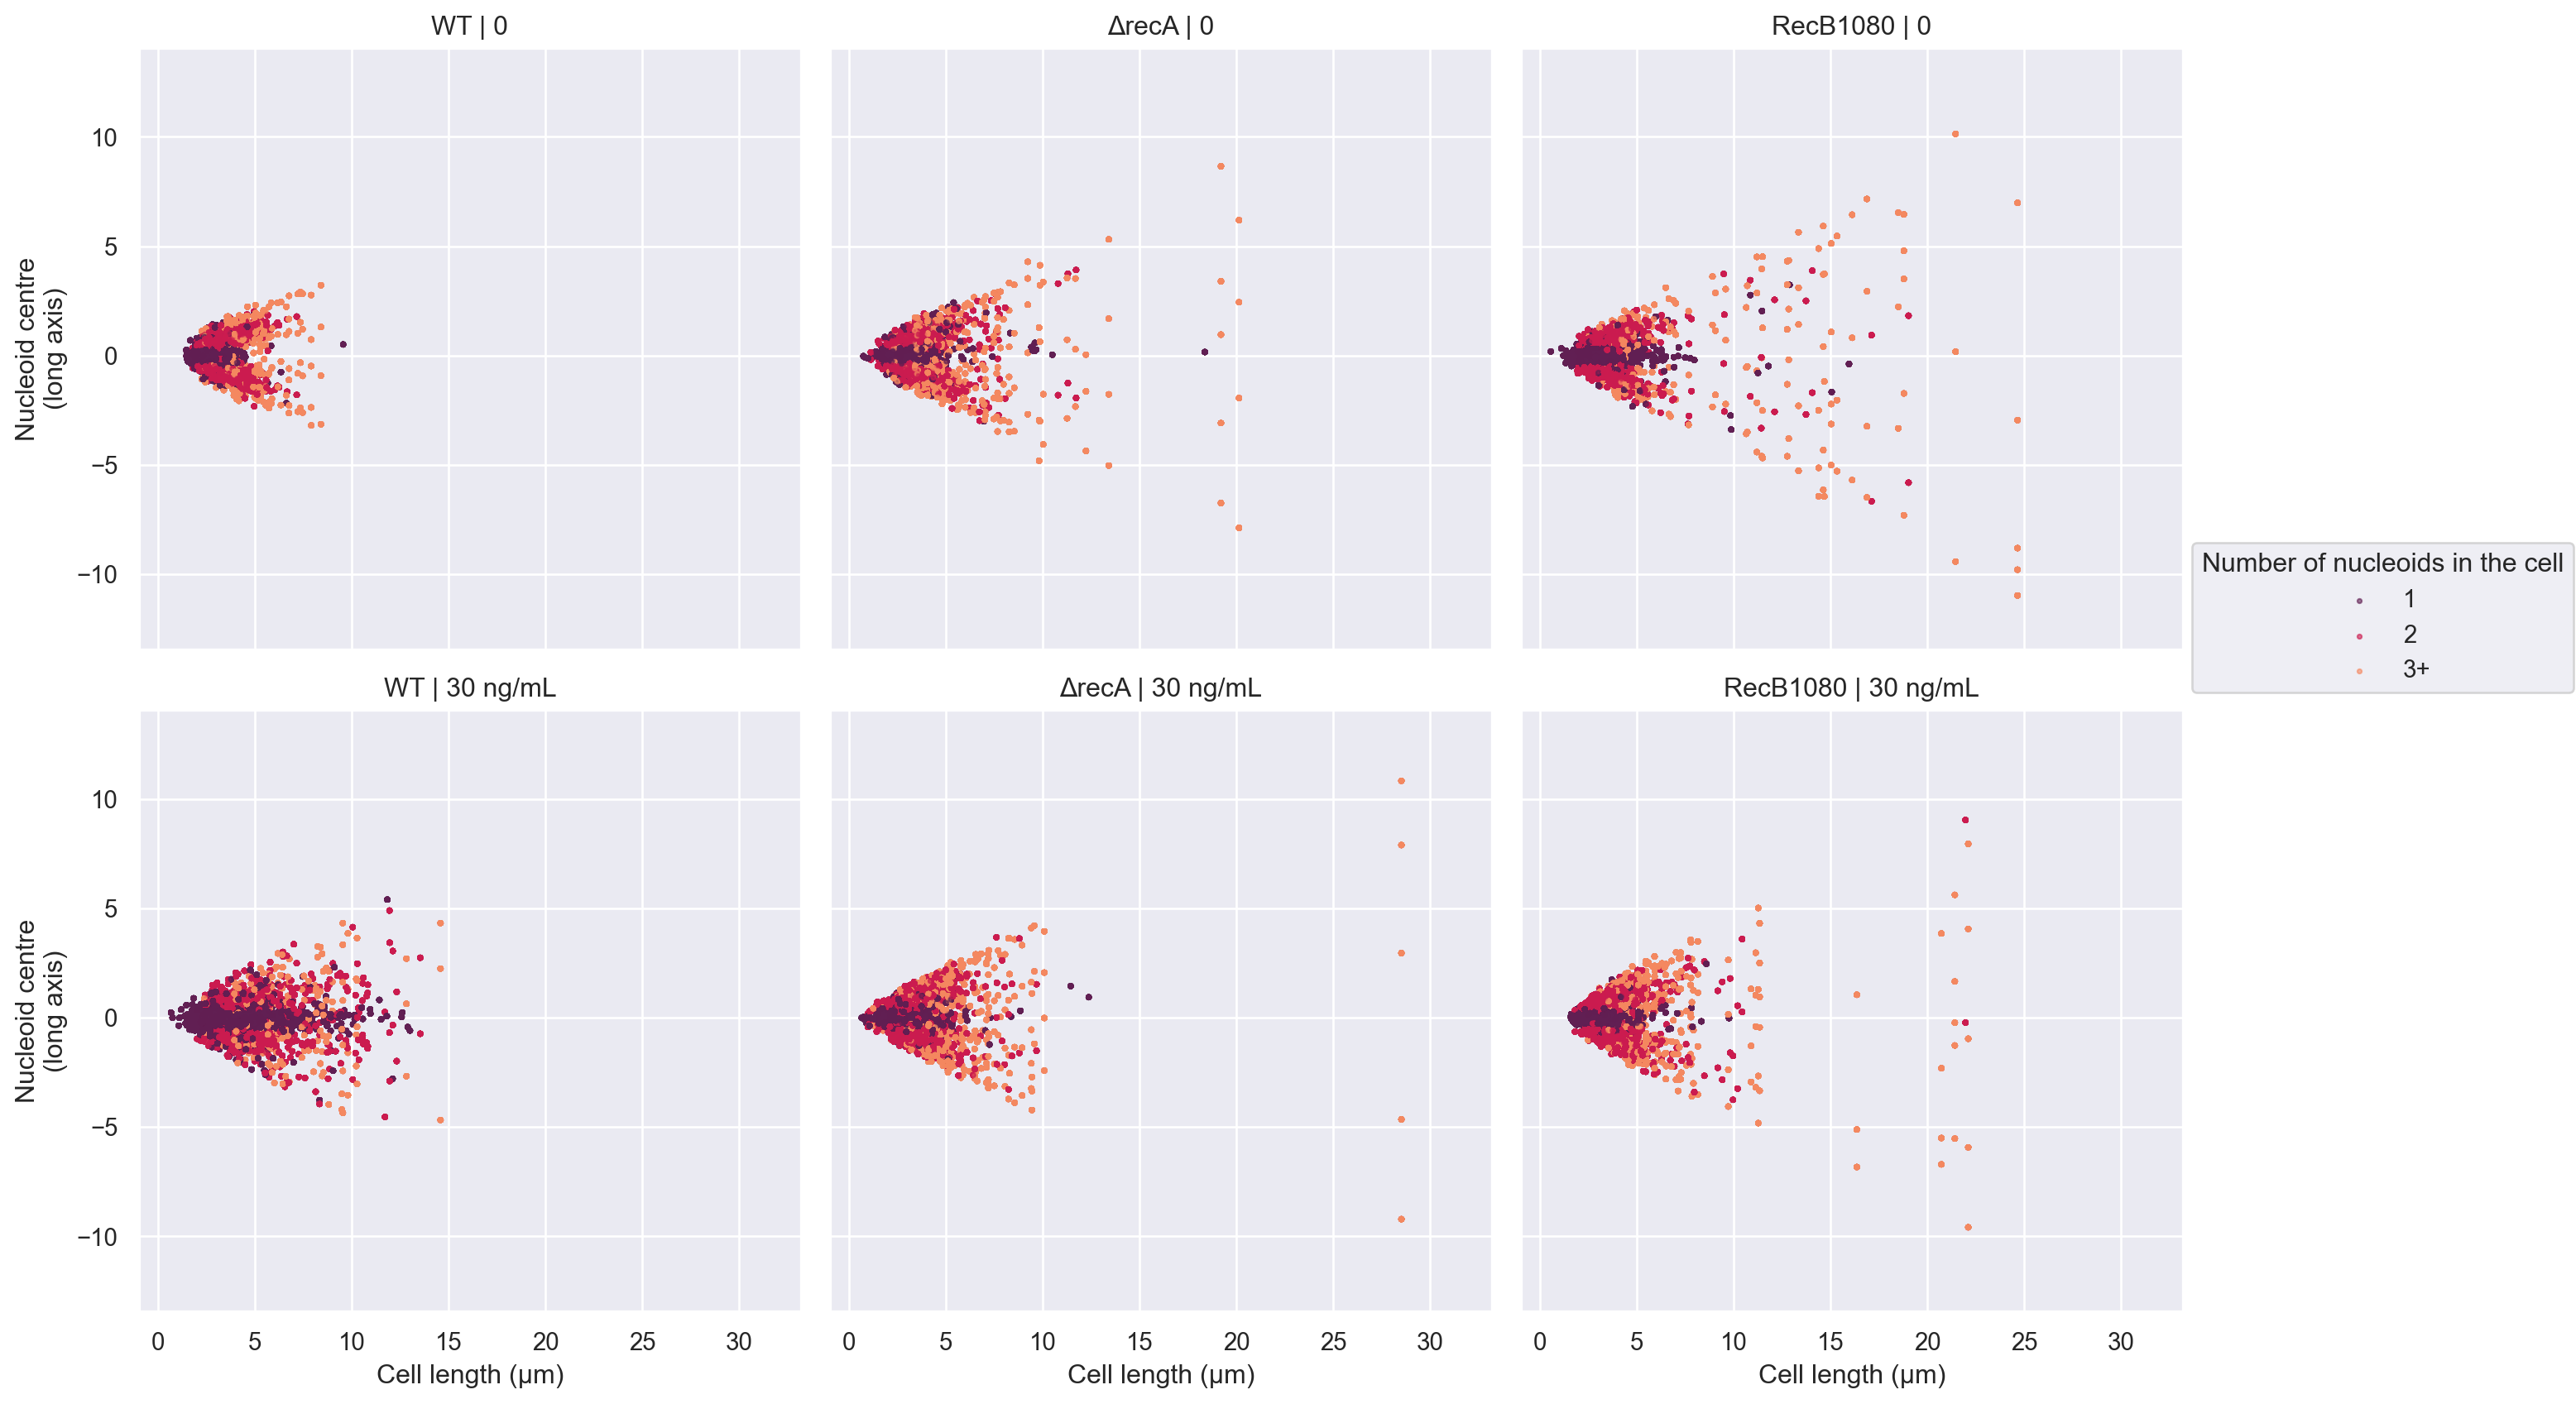

In [34]:
df = (data
      .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
      .Nucleoid
      .assign(NucleoidCount=lambda df: df.NucleoidCount.astype('str').replace({'3':'3+', '4':'3+', '5':'3+'}))
      )

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='NucleoidCount')
    .layout(size=(14,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=4))
    # .limit(x=(None, 10), y=(-3, 3))
    .scale(color=so.Nominal('rocket', order=['1', '2', '3+']))
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Number of nucleoids in the cell')
)

In [4]:
df = (data
      .Bacteria_large
      .assign(no_nucleoid=lambda df: df.NucleoidCount.eq(0).astype('int')*100,
              )
      .groupby(['Strain', 'Cipro'])
      .agg({'no_nucleoid':'mean'})
      .assign(no_nucleoid=lambda df: df.no_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'no_nucleoid':'Cells with no nucleoid'})
      )

display(df)

Cells with no nucleoid
Strain   Cipro                          
RecB1080 0                            9%
         30 ng/mL                     1%
WT       0                            1%
         30 ng/mL                     2%
ΔrecA    0                            4%
         30 ng/mL                     4%

In [3]:
df = (data
      .RecB_spots
      .assign(spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int')*100,
              long_spot=lambda df: df.TrackLength.ge(5)
              )
      .query('long_spot == True')
      .groupby(['Strain', 'Cipro'])
      .agg({'spot_in_nucleoid':'mean'})
      .assign(spot_in_nucleoid=lambda df: df.spot_in_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'spot_in_nucleoid':'DNA-bound RecB in a nucleoid'})
      )

display(df)

DNA-bound RecB in a nucleoid
Strain   Cipro                                
RecB1080 0                                 81%
         30 ng/mL                          81%
WT       0                                 70%
         30 ng/mL                          82%
ΔrecA    0                                 75%
         30 ng/mL                          78%

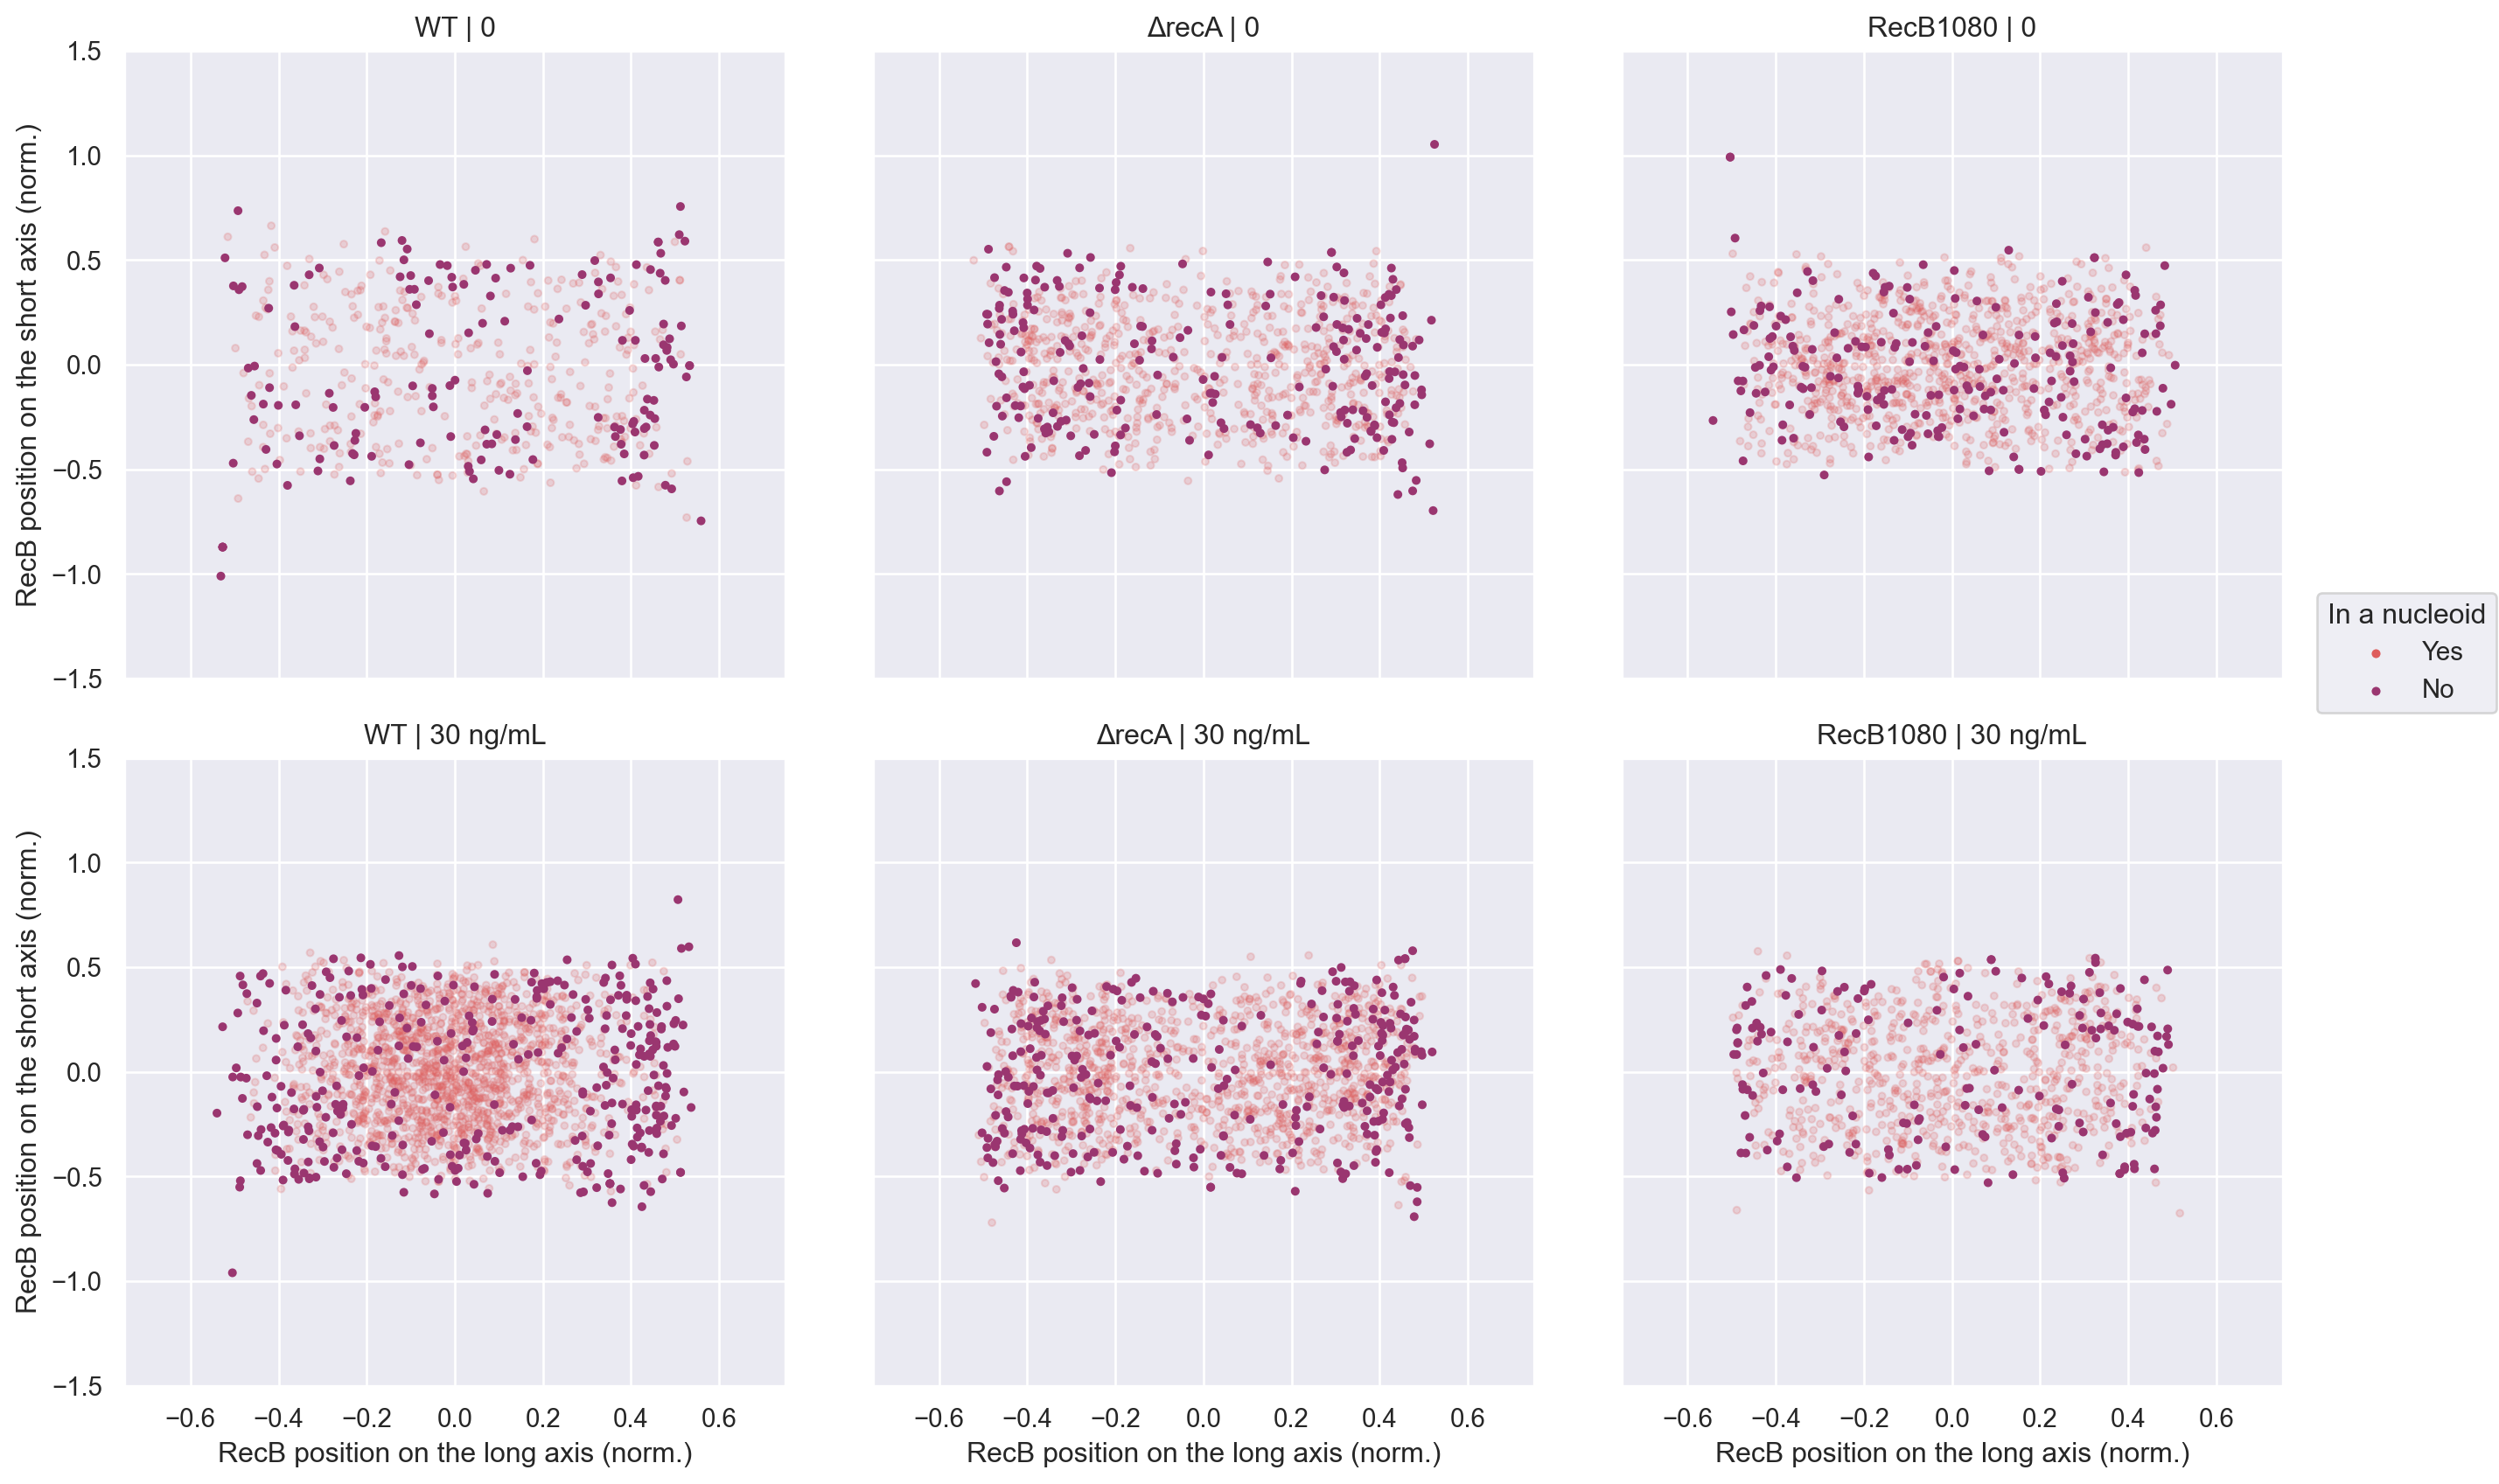

In [19]:
df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['normLongCoord', 'normShortCoord', 'spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['RecB_long', 'RecB_short', 'in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      )

(
    so.Plot(df, x='RecB_long', y='RecB_short', color='in_nucleoid')
    .layout(size=(14,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.2, fillalpha=.2, pointsize=6), data=df.query('in_nucleoid == "Yes"'))
    .add(so.Dots(marker='.', alpha=1, fillalpha=1, pointsize=6), data=df.query('in_nucleoid == "No"'))
    .limit(x=(-.75, .75), y=(-1.5, 1.5))
    .scale(color='flare')
    .label(x='RecB position on the long axis (norm.)', y='RecB position on the short axis (norm.)', color='In a nucleoid')
)

### Nucleoid/RecB colocalisation

Split by groups, normalised by cell length, cells with 1-2 nucleoids

Without normalisation to cell length:

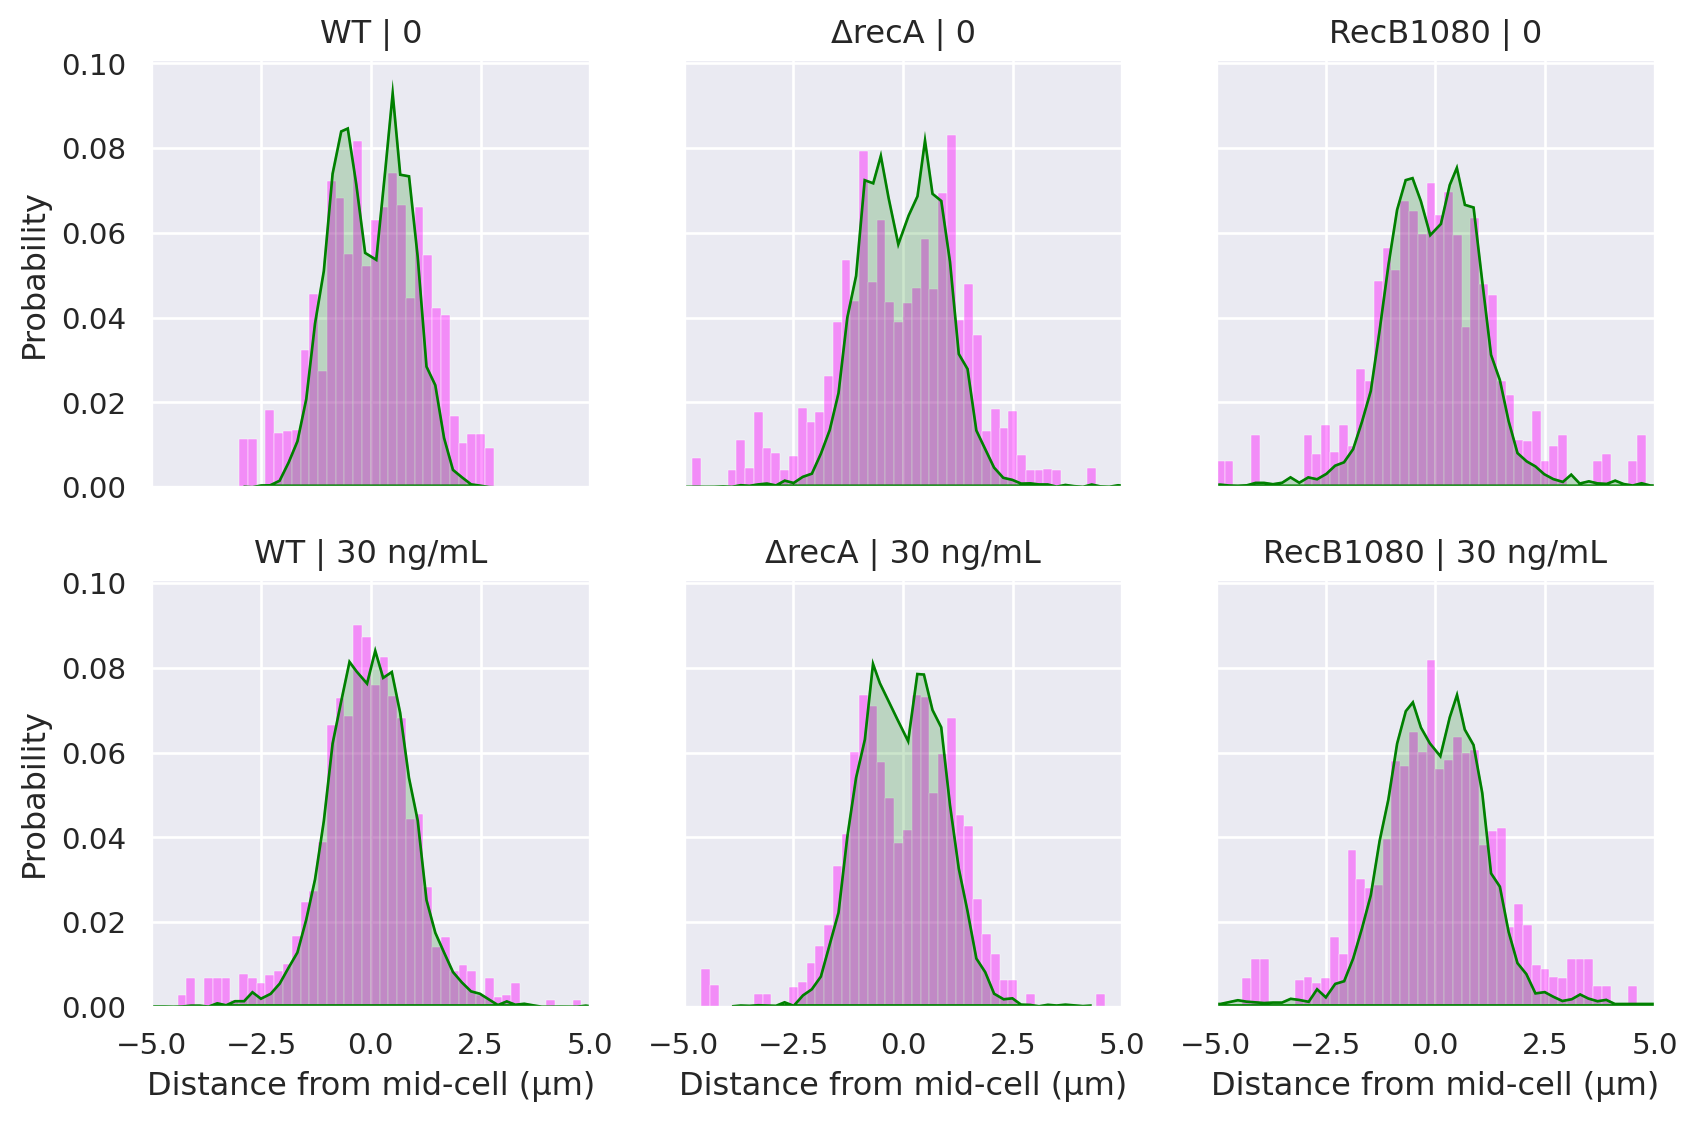

In [16]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .query('Time_min_bin < 90')
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Strain', 'Cipro', 'Time_min_bin', 'Object'], density=True, binsize=.2)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Strain', 'Cipro', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
    .facet(row='Cipro', col='Strain', order={'row':['0', '30 ng/mL'], 'col':['WT', 'ΔrecA', 'RecB1080']})
    .layout(size=(9,6))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell (µm)', y='Probability')
    .limit(x=(-5, 5), y=(0, None))
    # .save(loc='D:\DanielThedie\Figures\RecB_article_figures\\3_Nucleoid\RecB_Nucleoid_position_overlay.pdf', format='pdf', bbox_inches='tight')
)

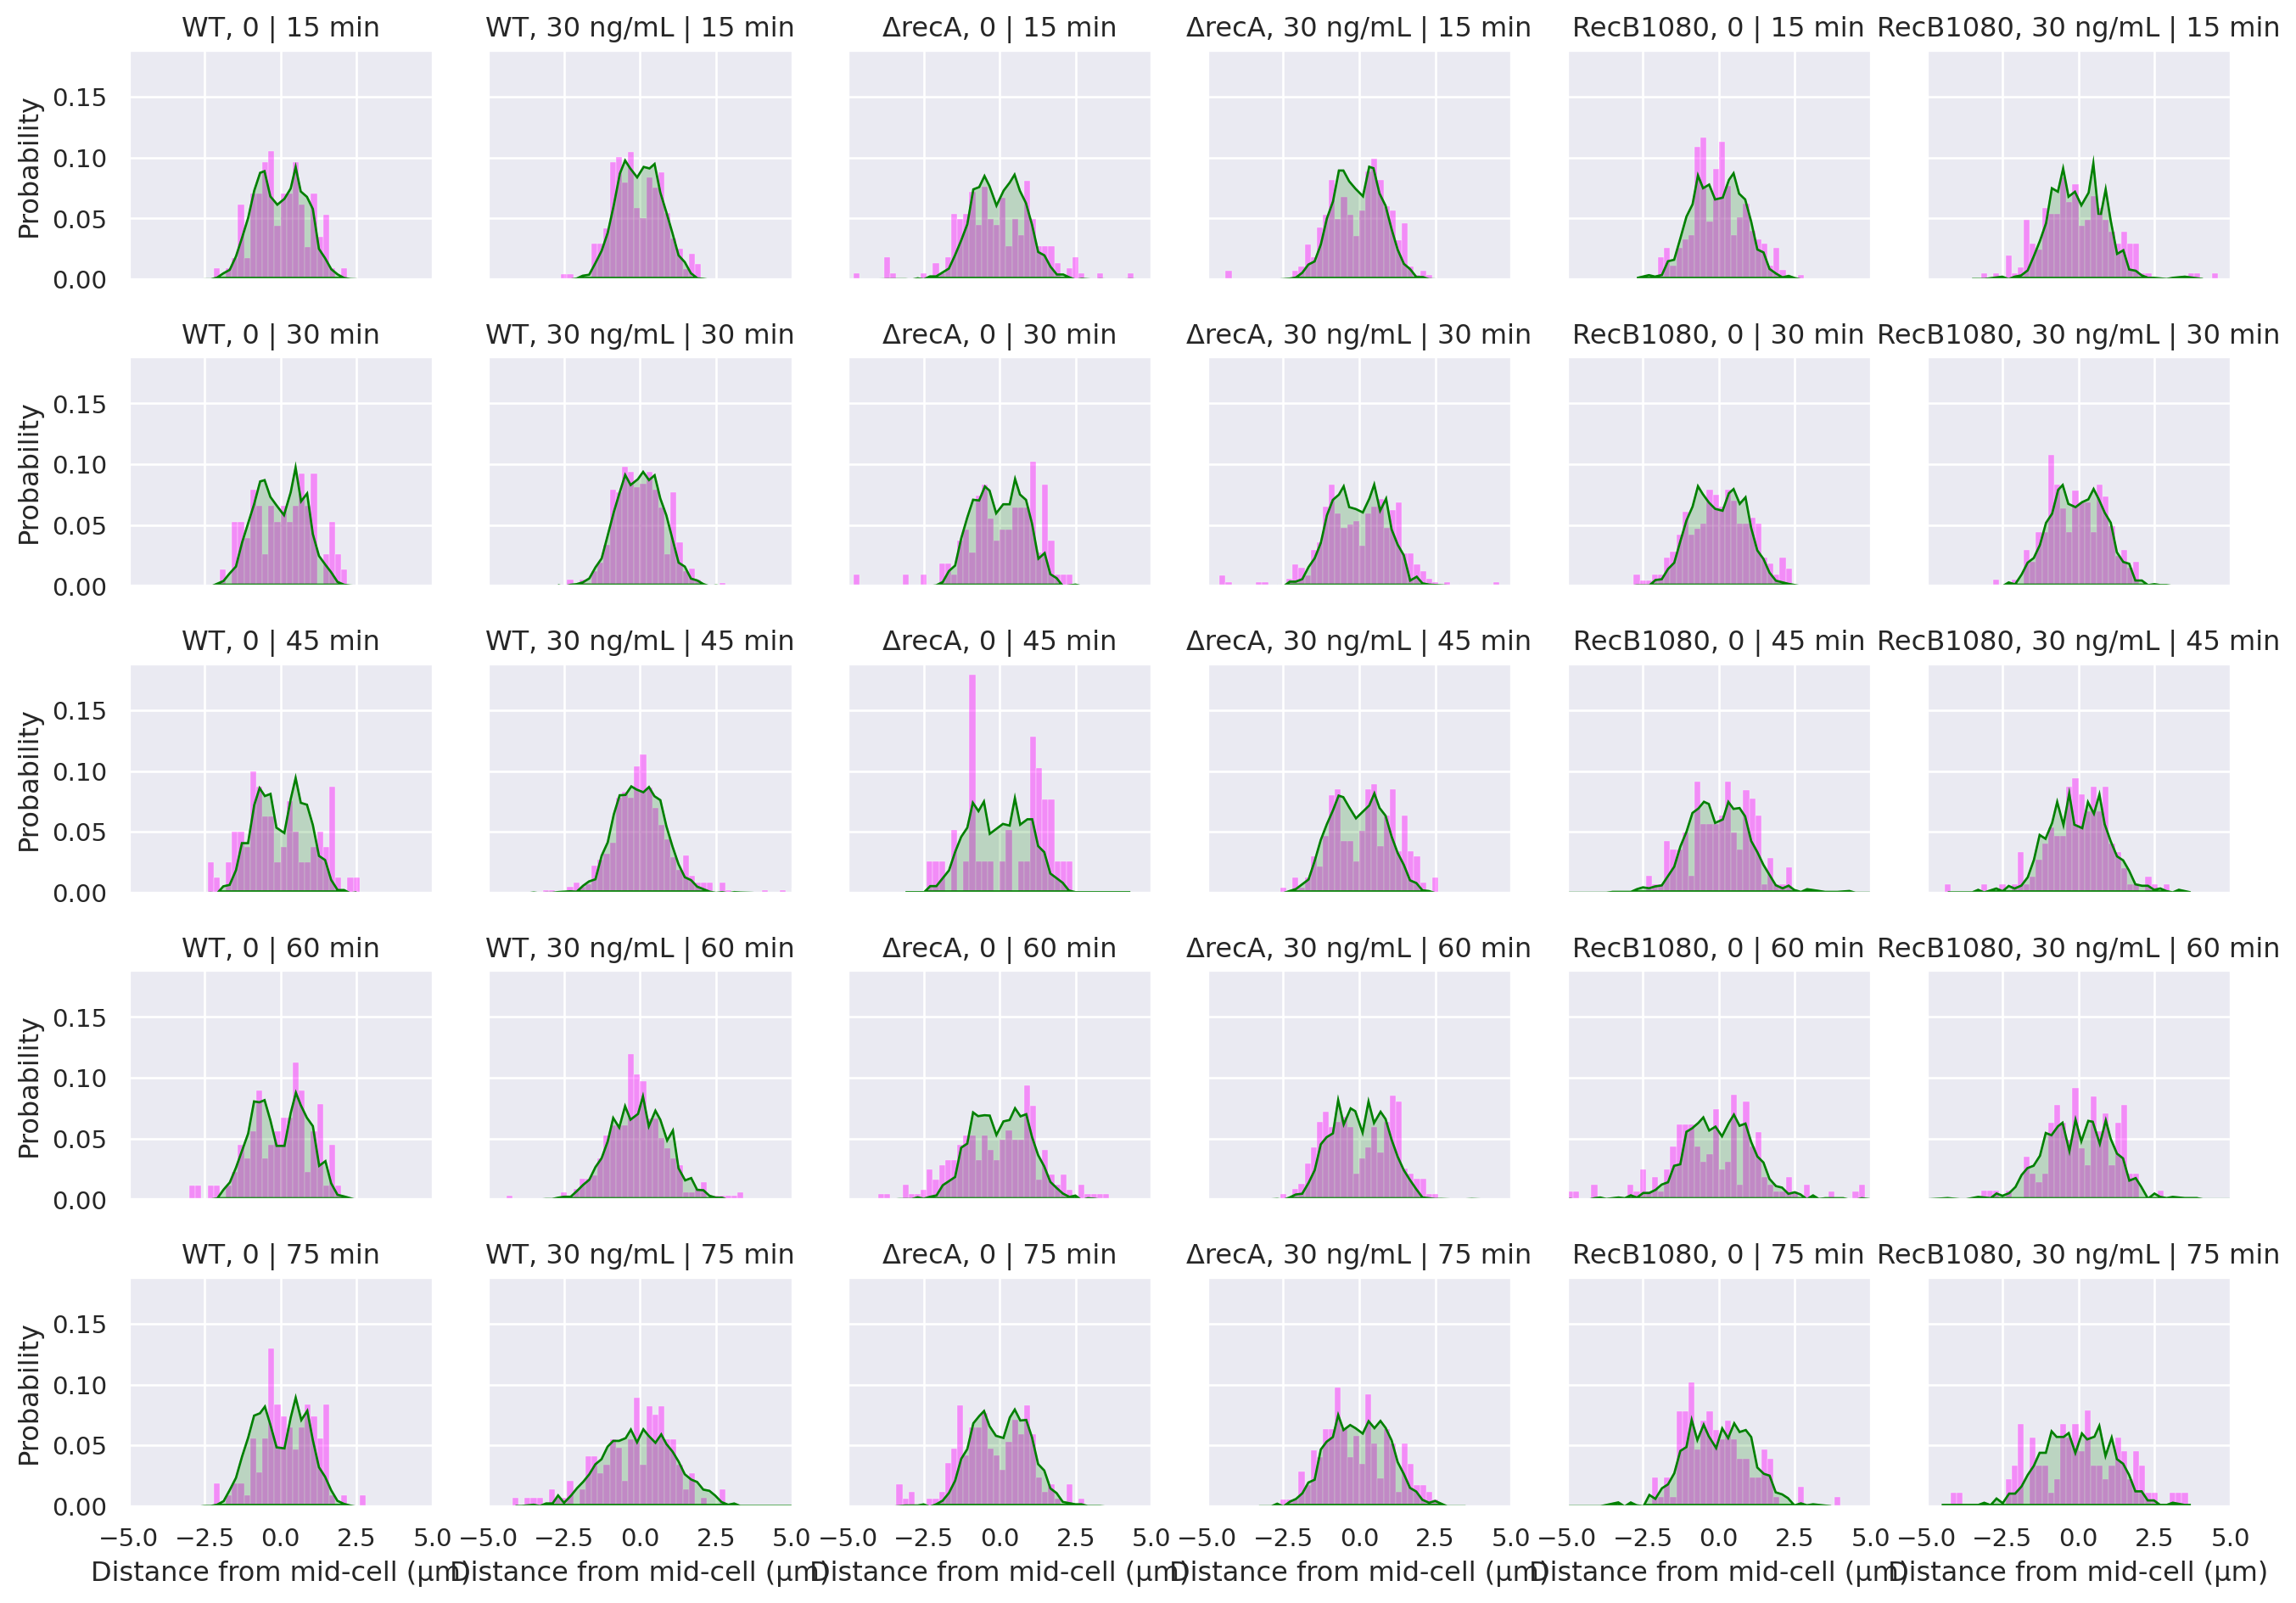

In [23]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Group', 'Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .query('Time_min_bin < 90')
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Group', 'Strain', 'Cipro', 'Time_min_bin', 'Object'], density=True, binsize=.2)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Group', 'Strain', 'Cipro', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
    .facet(row='Time_min_bin', col='Group', order={'col':['WT, 0', 'WT, 30 ng/mL', 'ΔrecA, 0', 'ΔrecA, 30 ng/mL', 'RecB1080, 0', 'RecB1080, 30 ng/mL']})
    .layout(size=(14,10))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell (µm)', y='Probability')
    .limit(x=(-5, 5), y=(0, None))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/RecB_Nucleoid_position_timepoints.pdf', format='pdf', bbox_inches='tight')
)

In [5]:
from pybacmman.selections import store_selection

df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      .query('Dataset == "240424_2" and in_nucleoid == "No"')
      )

store_selection(df,
            #     dsPath='D:\\Daniel\\BACMMAN\\Timelapse',
                dsName="Timelapse\\240424_2",
                objectClassIdx=0,
                selectionName='Spot_non_nucleoid',
                port=25333, python_proxy_port=25334, address='127.0.0.1'
                )